In [59]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [60]:
# Import packages
import pandas as pd                                                                                 # For loading the data into a DataFrame
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
import os                                                                                           # For setting environment variables

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [61]:
# Parameter
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
LABEL = ['classvalue']
SPLIT = ['sample']
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#FF8C00', '#006400']
# PALETTE = ['#8B0100', '#B86401', '#e4cb00', '#87CEFA', '#65A300', '#006401']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023_ALL.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Wonosobo_2023.tif'

/home/seviko/python/tf217/lib/python3.12/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


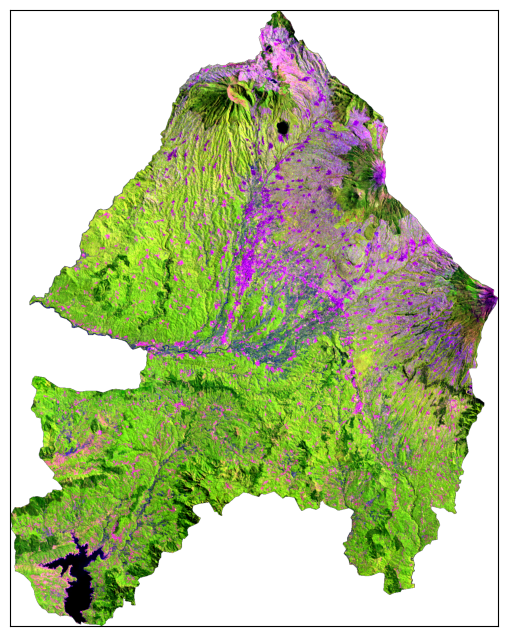

<Axes: >

In [62]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [63]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
4556,0.011145,0.013290,0.033145,0.024042,0.202352,0.110613,0.050085,0.357497,0.603189,0.293132,-0.718511,-0.293132,0.376655,0.787606,5,4,train
8745,0.019560,0.024757,0.054650,0.033392,0.368617,0.187833,0.077228,0.605847,0.653568,0.324890,-0.741771,-0.324890,0.417283,0.833872,50,6,train
17906,0.009467,0.013262,0.039635,0.024950,0.232465,0.086962,0.039195,0.404451,0.711441,0.455510,-0.708673,-0.455510,0.378634,0.806150,24,9,train
10857,0.013895,0.020220,0.047637,0.028167,0.360148,0.151340,0.055860,0.602503,0.731447,0.408236,-0.766360,-0.408236,0.460811,0.854924,49,6,test
4955,0.045547,0.058142,0.095955,0.102913,0.256060,0.171882,0.086935,0.266350,0.493083,0.196703,-0.454824,-0.196703,0.328214,0.426627,10,4,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13236,0.019863,0.023685,0.049012,0.034217,0.227405,0.123510,0.058802,0.384813,0.589092,0.296069,-0.645373,-0.296069,0.354926,0.738421,8,7,test
12178,0.025417,0.029982,0.060535,0.041725,0.340678,0.154778,0.062597,0.547068,0.689554,0.375211,-0.698240,-0.375211,0.424060,0.781774,6,7,train
14526,0.020454,0.022736,0.043512,0.028209,0.372935,0.137439,0.051996,0.628299,0.755272,0.461419,-0.791030,-0.461419,0.451039,0.859358,57,8,train
17931,0.011227,0.017745,0.042522,0.025060,0.266290,0.096574,0.042550,0.469845,0.724453,0.467713,-0.724606,-0.467713,0.388314,0.827973,24,9,train


In [64]:
# from ydata_profiling import ProfileReport
# ProfileReport(samples[FEATURES], title="Pandas Profiling Report")

In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

train_label = train_label - 1  # Make labels range from 0 to 8
test_label = test_label - 1  # Make labels range from 0 to 8

# Function to reshape array input
def reshape_input(array):
    return np.expand_dims(array, axis=-1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = tf.keras.utils.to_categorical(train_label.to_numpy())
test_output = tf.keras.utils.to_categorical(test_label.to_numpy())

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (14853, 15, 1)
Test features: (4043, 15, 1)
Train label: (14853, 9)
Test label: (4043, 9)


In [66]:
filtered_train = train[FEATURES + LABEL]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]

print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())

Label 1 848
Label 2 1052
Label 3 1102
Label 4 1960
Label 5 603
Label 6 2981


In [ ]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (None, 1)

# Model parameter
neuron = 64
drop = 0.4
kernel = 2
pool = 2

# Make sequential model
model = tf.keras.Sequential([
  tf.keras.Input(input_shape),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.GlobalAveragePooling1D(),
  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(neuron * 2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(neuron * 1, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, None, 128)      │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, None, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_10            │ (None, None, 128)      │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, None, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_11            │ (None, None, 64)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,401 (294.54 KB)

 Trainable params: 75,273 (294.04 KB)

 Non-trainable params: 128 (512.00 B)

In [68]:
# Train the model
from sklearn.utils.class_weight import compute_class_weight

train_output_flat = np.argmax(train_output, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_output_flat), y=train_output_flat)
class_weights = dict(enumerate(class_weights))

print(class_weights)

# Compline the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-6
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop, lr_callback],  
    epochs=500,
    class_weight=class_weights
)

{0: np.float64(1.9461477987421383), 1: np.float64(1.5687579214195184), 2: np.float64(1.4975801572897762), 3: np.float64(0.8420068027210884), 4: np.float64(2.7368711995577666), 5: np.float64(0.5536173543553617), 6: np.float64(0.9800079176563737), 7: np.float64(0.6352322299204516), 8: np.float64(0.8149794238683128)}
Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.1213 - loss: 10.7277 - val_accuracy: 0.1724 - val_loss: 10.5327 - learning_rate: 1.0000e-04
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.1220 - loss: 10.4980 - val_accuracy: 0.2028 - val_loss: 10.3232 - learning_rate: 1.0000e-04
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1301 - loss: 10.2618 - val_accuracy: 0.2046 - val_loss: 10.1182 - learning_rate: 1.0000e-04
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1322 - loss: 10.0599 - val_accuracy: 0.2404 - val_loss: 9.9177 - learning_rate: 1.0000e-04
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

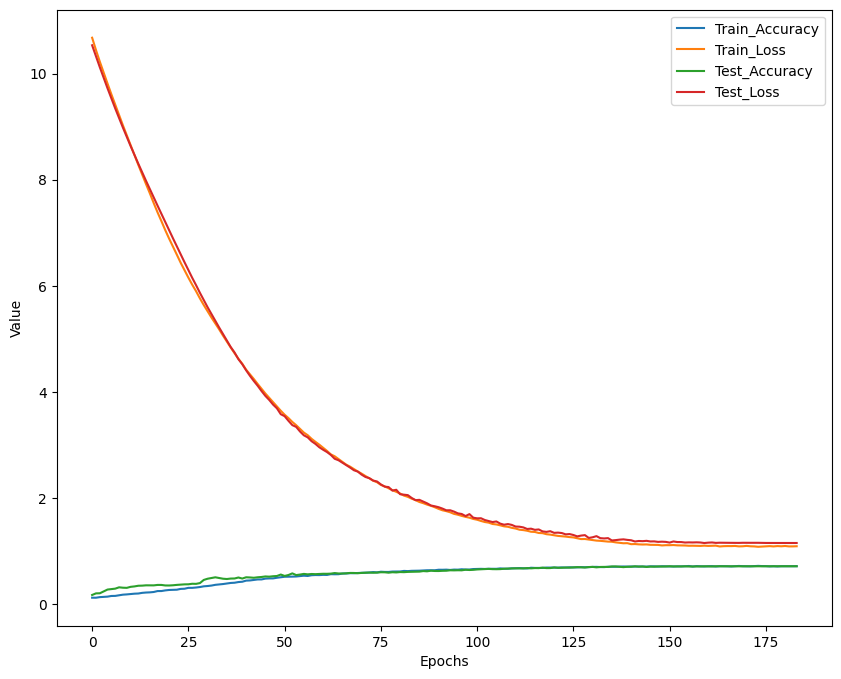

In [69]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       247
           1       0.77      0.82      0.80       392
           2       0.99      0.76      0.86       353
           3       0.47      0.84      0.60       293
           4       0.91      0.68      0.78       398
           5       0.73      0.58      0.64       678
           6       0.58      0.63      0.60       792
           7       0.86      0.62      0.72       605
           8       0.66      1.00      0.79       285

    accuracy                           0.71      4043
   macro avg       0.76      0.76      0.74      4043
weighted avg       0.75      0.71      0.72      4043



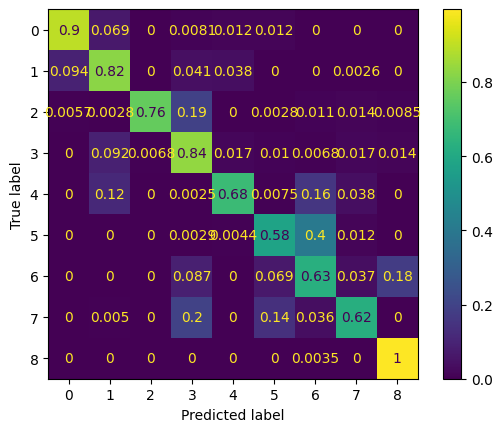

In [70]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


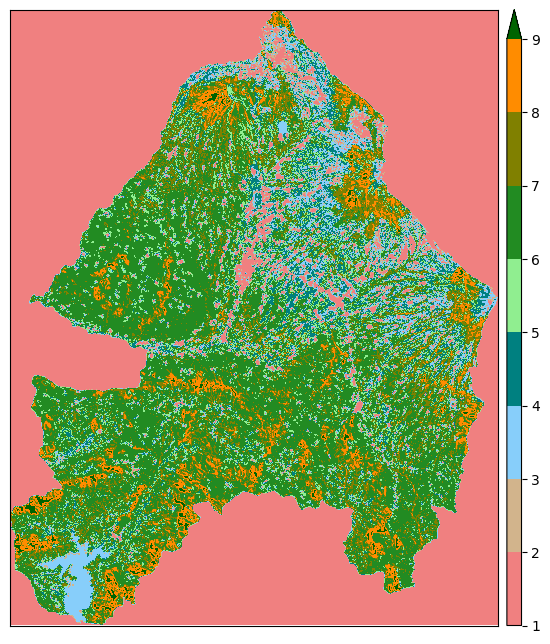

Nilai nodata: None


In [74]:
# Predict image using the model
image_input = []
used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
for i in used_image_feature:
  image_input.append(image.read(i))
image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction + 1, cmap=cmap, norm=norm, figsize=plot_size)

nodata_value = image.nodata
print("Nilai nodata:", nodata_value)

In [72]:
# # Save file to drive
# save_location = 'saved_data/'
# name = 'Output.tif'
# location = save_location + name

# new_dataset = rasterio.open(
#       location,
#       mode='w', driver='GTiff',
#       height = prediction.shape[0], width = prediction.shape[1],
#       count=1, dtype=str(prediction.dtype),
#       crs=crs,
#       transform=transform
# )
# new_dataset.write(prediction, 1)
# new_dataset.close()